# Final Project - Lập Trình Song Song

## Thông tin nhóm
**Nhóm: 12**

**Thành viên 1:**

- Họ và tên: Nguyễn Hữu Đạt
- MSSV: 19127003
- Email: 19127003@student.hcmus.edu.vn

**Thành viên 2:**

- Họ và tên: Nguyễn Minh Trí
- MSSV: 19127595
- Email: 19127595@student.hcmus.edu.vn

In [ ]:
from PIL import Image
import numpy as np
def show_pnm(file_name):
  with open(file_name, 'r') as f:
    vals = f.read().split()
  w = int(vals[1])
  h = int(vals[2])
  if vals[0] == 'P2': # Grayscale
    pixels = np.array(vals[4:], dtype=np.uint8).reshape((h, w))
  elif vals[0] == 'P3': # RGB
    pixels = np.array(vals[4:], dtype=np.uint8).reshape((h, w, 3))
  else:
    return None
  
  return Image.fromarray(pixels)

In [ ]:
from numba import cuda
major, minor = cuda.get_current_device().compute_capability
print(f'GPU compute capability: {major}.{minor}')

GPU compute capability: 7.5


## 1. Mô tả đề tài

**Mô tả bài toán:** 
- Hình ảnh thường được hiển thị ở nhiều độ phân giải khác nhau ở các thiết bị khác nhau, sự thay đổi này gây ra khó khăn khi xem ảnh. Việc thay đổi tỷ lệ hoặc cắt ảnh không phải là ý tưởng tốt trong trường hợp này do có thể làm mất mát thông tin của ảnh khi tự động thực hiện. Vì vậy Seam carving ra đời nhằm tự động xử lý các trường hợp trên một cách hiệu quả nhất. 
- Seam carving là một thuật toán dùng để thay đổi kích thước của hình ảnh một cách tự nhiên, hiệu quả hơn so với các thuật toán trước đó bằng cách loại bỏ những pixel ít quan trọng trên đường seam và giữ lại những pixel quan trọng khi thu nhỏ ảnh.
- Việc xoá các pixel ít quan trọng ở vị trí ngẫu nhiên sẽ làm cho bức ảnh méo mó, không còn tự nhiên như ảnh ban đầu nữa. Để giải quyết vấn đề này khi thu nhỏ ảnh theo chiều ngang thuật toán Seam Carving xoá cột theo đường seam, là một đường đi từ trên xuống được nối với nhau bằng các pixel và các pixel này là hàng xóm của nhau. Khi muốn thu nhỏ chiều cao của ảnh, sẽ tìm và xoá đường seam theo chiều ngang.
<center>
<img src="https://drive.google.com/uc?id=1QojQL2Z5cuyFRliLLJj8nFAlcFasgZG2" alt="alt text" title="image Title" />
</center>

**Đầu vào:**  Ảnh cần được thu nhỏ, ảnh màu RGB và số lượng seam cần xoá.

**Đầu ra:** Ảnh RGB đã được giảm kích thước theo chiều ngang.

**Ứng dụng của đồ án:** Được ứng dụng để thay đổi kích thước của ảnh mà không làm mất đi các đối tượng quan trọng của ảnh, giúp ảnh trông tự nhiên hơn so với các thuật toán trước đó. Hiển thị độ phân giải khác nhau trên nhiều thiết bị khác nhau.

**Tốc độ:** Cần tăng tốc độ giúp xử lý ảnh đạt tới thời gian thực

## 2. Cài đặt tuần tự Seam Carving

### Quá trình cài đặt

**Mô tả giải thuật:**
- **Bước 1:** Đưa ảnh màu RGB về ảnh xám
- **Bước 2:** Tính điểm năng lượng (độ quan trọng) của các pixels bằng tổng tuyệt đối của 2 phép tích chập ảnh xám với xSobel và ySobel. 
- **Bước 3:** Từ các điểm năng lượng, tính bảng giá trị của seam để tìm đường seam có giá trị nhỏ nhất (là giá trị nhỏ nhất ở dòng cuối cùng của bảng). 
- **Bước 4:** Từ điểm có giá trị nhỏ nhất, truy vết để tìm các pixels tạo nên đường seam đó (đi từ dưới lên), sau đó xoá đường seam đó bằng cách dịch tất cả pixel liền kề đường seam qua trái 1 pixel.
- **Bước 5:** Lặp lại từ bước 2 tới bước 4 tới khi đủ số đường seam muốn xoá.

**Thiết kế thuật toán:**
- `RGB2Gray`: Dùng để chuyển ảnh từ ảnh màu RGB thành ảnh xám
- `pixelsImportant`: Dùng để tính độ quan trọng của từng pixel bằng tổng tuyệt đối tích chập ảnh xám với 2 filter xSobel và ySobel.
- `seamsScore`: Dùng để tính giá trị tích luỹ đường đi nhỏ nhất dựa theo bảng độ quan trọng. Bắt đầu từ dòng thứ 1, giá trị đường seam hiện tại bằng giá trị nhỏ nhất của tổng chính nó (i;j) với 3 điểm ảnh ngay trên nó (i-1; j-1); (i-1; j); (i-1; j+1). Ở đây ta tính từ trên xuống nên giá trị ở hàng cuối cùng là kết quả cuối cùng của các đường seam. Giá nhị nhỏ nhất ở hàng cuối cùng chính là giá trị seam nhỏ nhất (ít quan trọng nhất) cần tìm.
- `seamCarvingByHost`: 
  - Chuyển ảnh RGB thành ảnh xám lưu vào grayPixels
  - Tính năng lượng của mỗi pixel (độ quan trọng) bằng hàm pixelsImportant
  - Tạo vòng lặp có số lần lặp bằng với số đường seam cần xoá. Ở mỗi vòng lặp sẽ là một vòng lặp khác đi từ dòng cuối cùng tới dòng đầu tiên của mảng, vòng lặp này có nhiệm vụ xoá pixel có đường seam nhỏ nhất bằng cách dịch tất cả các pixel qua trái 1 đơn vị, sau đó cập nhập lại các giá trị và truy vết tới chỉ số cột hàng xóm tạo nên đường seam đó ở dòng trên; lặp đi lặp lại đến khi nào xoá được pixel ở hàng đầu tiên sẽ hoàn thành việc xoá 1 đường seam.
  - Biến outputs là kết quả cuối cùng. Giải phóng các vùng nhớ được cấp phát ở trên và in ra thời gian xử lý.


### Thử nghiệm và đánh giá

Ở đây với phiên bản cài trên Host, ta sẽ truyền vào một đường dẫn tới ảnh, tên của ảnh output và số seam cần xoá theo chiều ngang (số đường seam cần tìm và xoá).

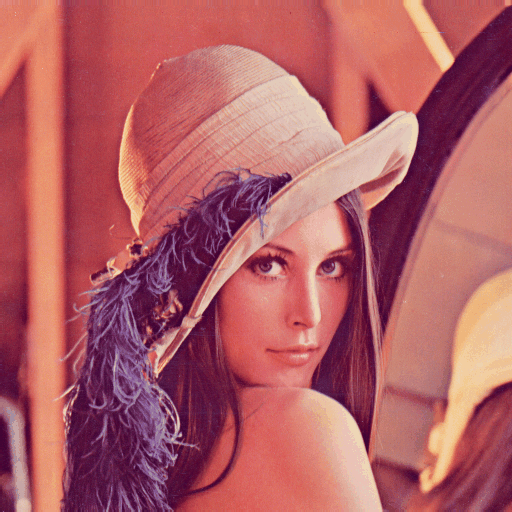

In [ ]:
show_pnm("inn.pnm")

In [ ]:
! nvcc sequential.cu -o sequential

In [ ]:
! ./sequential inn.pnm out.pnm 100

**********GPU info**********
Name: Tesla T4
Compute capability: 7.5
Num SMs: 40
Max num threads per SM: 1024
Max num warps per SM: 32
GMEM: 15843721216 bytes
CMEM: 65536 bytes
L2 cache: 4194304 bytes
SMEM / one SM: 65536 bytes
****************************

Image size (width x height): 512 x 512

Number of seam removed: 100

Image size after seam carving (width_new x height): 412 x 512

Processing time (use host): 416.012299 ms



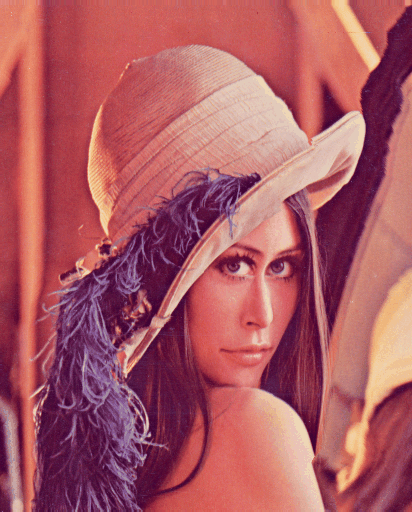

In [ ]:
show_pnm("out_host.pnm")

Như kết quả trên, sau khi đưa ảnh qua seam carving thì độ phân giải ảnh đã thay đổi. Do truyền vào 100 lần xoá seam nên kết quả chiều dài của ảnh của ảnh đã được giảm 100 pixels. Nhìn kết quả trên mặc dù giảm tới 100 pixels chiều dài nhưng bức ảnh vẫn giữ được những đối tượng quan trọng của ảnh.

## 3. Cài đặt song song Seam Carving

### Phân tích
Những bước có thể song song hoá từ phiên bản cài đặt tuần tự:
- Chuyển ảnh RGB thành ảnh xám
- Tính năng lượng (độ quan trọng) của pixel
- Tính điểm của đường seam từ độ quan trọng của pixel
- Xoá seam có độ quan trọng ít nhất

### Thiết kế
- Chuyển đổi từ ảnh RGB sang ảnh xám: Do mỗi phép tính là độc lập với nhau nên mỗi thread tính độ xám của một pixel.
- Tính năng lượng (độ quan trọng) của mỗi pixel: Mỗi thread sẽ thực hiện 1 tích chập trên ảnh xám.
- Tính bảng điểm seam: Thực hiện song song hoá ở mỗi dòng, mỗi pixel trên cùng 1 hàng sẽ được tính song song, sau đó đợi cả hàng hoàn thành mới tiếp tục tính hàng tiếp theo. Ta dùng `__syncthreads()` để đợi kết quả mỗi dòng hoàn thành rồi mới tiếp tục tính dòng tiếp theo.
- Xoá seam là việc dịch toàn bộ pixels bên phải đường seam qua trái 1 pixel. Do đó mỗi dòng có tính độc lập với nhau nên mỗi thread sẽ xử lý 1 dòng.

### Thử nghiệm và đánh giá
Sử dụng ảnh có kích thước 512x512 và giảm 100 độ phân giải theo chiều ngang (xoá 100 seam ít quan trọng nhất)

In [ ]:
! nvcc parallel.cu -o parallel

In [ ]:
! ./parallel inn.pnm out.pnm 100 

**********GPU info**********
Name: Tesla T4
Compute capability: 7.5
Num SMs: 40
Max num threads per SM: 1024
Max num warps per SM: 32
GMEM: 15843721216 bytes
CMEM: 65536 bytes
L2 cache: 4194304 bytes
SMEM / one SM: 65536 bytes
****************************

Image size (width x height): 512 x 512

Number of seam removed: 100

Processing time (use host): 442.308350 ms

Processing time (use device): 127.809792 ms

Image size after seam carving (new_width x height): 412 x 512

Error between device result and host result: 0.112662


Ở bước này không cần hiển thị ảnh vì chỉ cần đo độ lỗi của hàm kernel so với hàm ở host sẽ dễ dàng quan sát hơn. Ở đây độ lỗi giữa 2 hàm không quá chênh lệch nhiều nên cài đặt song song này đúng. Cải thiện đáng kể thời gian so với chạy tuần tự (nhanh gấp 4 lần).

## 4. Tối ưu quá trình cài đặt song song

### 4.1 Phiên bản tối ưu 1

#### Phân tích

- Ở bước tính độ quan trọng của mỗi pixels đang được thực hiện đọc ghi dữ liệu ở GMEM. Chuyển thành sử dụng SMEM giúp cải thiện ở bước này vì tốc độ đọc ghi dữ liệu ở SMEM nhanh hơn nhiều GMEM giúp các thread trong cùng block tăng tốc độ xử lý.

#### Thiết kế
- Chuyển đổi ảnh đầu vào đang ở GMEM sang SMEM giúp giảm thời gian truy xuất khi thực hiện phép tích chập. Việc sử dụng SMEM sẽ hiệu quả khi các thread trong cùng block có thể sử dụng những kết quả này nhanh chóng hơn. Block sẽ đọc dữ liệu giá trị pixel 1 lần đưa từ GMEM vào SMEM, sau đó các thread cùng chung 1 block thực hiện các phép tính toán trên SMEM. Kết quả sau cùng sẽ được ghi từ SMEM vào lại GMEM. 
- Cài đặt shared memory trên hàm kernel này `pixelsImportantKernel`

#### Thử nghiệm và đánh giá
**Kịch bản thử nghiệm:** Vẫn sử dụng tham số như bản thử nghiệm cài đặt song song trên, nhưng sử dụng hàm kernel khác.

In [ ]:
! nvcc parallel_optimized_v1.cu -o parallel_optimized_v1

In [ ]:
! ./parallel_optimized_v1 inn.pnm out.pnm 100 

**********GPU info**********
Name: Tesla T4
Compute capability: 7.5
Num SMs: 40
Max num threads per SM: 1024
Max num warps per SM: 32
GMEM: 15843721216 bytes
CMEM: 65536 bytes
L2 cache: 4194304 bytes
SMEM / one SM: 65536 bytes
****************************

Image size (width x height): 512 x 512

Number of seam removed: 100

Processing time (use host): 452.550232 ms

Processing time (use device): 127.573059 ms

Image size after seam carving (new_width x height): 412 x 512

Error between device result and host result: 0.112662


**Nhận xét:** Sau khi sử dụng SMEM ở bước tính độ quan trọng thì tốc độ không cải thiện, đôi khi còn chậm hơn so với không dùng SMEM.

### 4.2 Phiên bản tối ưu 2

#### Phân tích
- Vẫn tiếp tục tối cải thiện tốc độ bằng cách sử dụng loại bộ nhớ nhớ khác có tốc độ truy xuất nhanh hơn, sử dụng thêm CMEM.
- Do filter này chỉ cần đọc, nên bộ nhớ `constant memory` là hợp lý trong trường hợp này.

#### Thiết kế
- Tương tự như phiên bản tối ưu thứ nhất nhưng sử dụng CMEM lưu giá trị của filter xSobel và ySobel và đọc dữ liệu của 2 filter trực tiếp từ CMEM.
- Thay đổi hàm kernel `pixelsImportantKernel`, đọc dữ liệu filter trên `constant memory`

#### Thử nghiệm và đánh giá

In [ ]:
! nvcc parallel_optimized_v2.cu -o parallel_optimized_v2

In [ ]:
! ./parallel_optimized_v2 inn.pnm out.pnm 100 

**********GPU info**********
Name: Tesla T4
Compute capability: 7.5
Num SMs: 40
Max num threads per SM: 1024
Max num warps per SM: 32
GMEM: 15843721216 bytes
CMEM: 65536 bytes
L2 cache: 4194304 bytes
SMEM / one SM: 65536 bytes
****************************

Image size (width x height): 512 x 512

Number of seam removed: 100

Processing time (use host): 434.522308 ms

Processing time (use device): 125.527199 ms

Image size after seam carving (new_width x height): 412 x 512

Error between device result and host result: 0.112662


**Nhận xét:** Tốc độ xử lý đã cải thiện hơn so với phiên bản song song và phiên bản tối ưu thứ 1.

## 5. Đánh giá kết quả


<center>

|      Phiên bản      |  Thời gian(ms)|
| --------------------| ------------ |
| sequential          |    416.97    |
|                     |              |
| parallel            |    127.8     |
| parallel_optimized_1|    127.5     |
| parallel_optimized_2|    125.5     |

</center>


## 6. Tổng kết


**Nguyễn Hữu Đạt**

- **Khó khăn gặp phải:** Chưa có nhiều kinh nghiệm trong việc song song hoá các bài toán tuần tự, ngoài ra chưa có đủ kiến thức chuyên sâu về các giải pháp tối ưu trong quá trình song song hoá.
- **Những kiến thức học được:** Tiếp cận và biết đến bài toán Seam Carving, học được cách tối ưu và song song hoá nó, ngoài ra còn hiểu được các ứng dụng của việc song song hoá trong thực tế thông qua bài toán này.


**Nguyễn Minh Trí**

- **Khó khăn gặp phải:** Lần đầu làm quen với lập trình song song nên gặp khó khăn trong việc tiếp cận cách giải bài toán.
- **Những kiến thức học được:**Ứng dụng và cách cài đặt của thuật toán Seam Carving và cách tối ưu một bài toán song song.

**Sẽ làm gì nếu có thêm thời gian**

- Khi xoá nhiều seam (giảm nhiều pixel) so với ảnh gốc sẽ dẫn tới hình ảnh có thể bị méo mó, nên nếu có thêm thời gian nhóm em sẽ cài đặt phiên bản cải thiện của thuật toán này để giúp ảnh đầu ra tự nhiên hơn với bài báo `Improved seam carving with forward energy` để giữ lại dữ liệu quan trọng tốt hơn.
- Cải tiến tốc độ ở bước truy vết đường seam từ bảng giá trị của seam
- Một số bước chưa được sử dụng shared memory, nên có thể cải thiện thêm tốc độ bằng sử dụng shared memory ở các bước đó. 

## 7. Nguồn tham khảo

https://github.com/kalpeshdusane/Seam-Carving-B.E.-Project

https://andrewdcampbell.github.io/seam-carving 

https://www.cs.cmu.edu/afs/andrew/scs/cs/15-463/f07/proj2/www/wwedler/
